<a href="https://colab.research.google.com/github/Adarsh-hello/deepfake_detection/blob/main/deepfake_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
!pip install -U gdown

import gdown


file_id = "1ZrwaDF4HBWwAs8_CqDrVsIKwWc8Oc_uE"
output = "dataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1ZrwaDF4HBWwAs8_CqDrVsIKwWc8Oc_uE
From (redirected): https://drive.google.com/uc?id=1ZrwaDF4HBWwAs8_CqDrVsIKwWc8Oc_uE&confirm=t&uuid=500e5a9f-552d-4a7b-b8eb-2e350d7f8047
To: /content/dataset.zip
100%|██████████| 1.80G/1.80G [00:26<00:00, 67.2MB/s]


'dataset.zip'

In [ ]:

zip_path = '/content/dataset.zip'
extract_path = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")


✅ Dataset extracted!


In [ ]:
train_dir = "/content/data/Train"
val_dir = "/content/data/Validation"
test_dir = "/content/data/Test"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/data/Train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=['Real', 'Fake'],
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    '/content/data/Validation',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=['Real', 'Fake'],
    shuffle=False
)



Found 139996 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [ ]:
print("✅ Label mapping:", train_data.class_indices)


✅ Label mapping: {'Real': 0, 'Fake': 1}


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
cw = dict(enumerate(class_weights))
print("📊 Class Weights:", cw)


📊 Class Weights: {0: np.float64(0.999957143469379), 1: np.float64(1.0000428602043003)}


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,074 (6.48 MB)

 Trainable params: 1,699,074 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 187s 41ms/step - accuracy: 0.8105 - loss: 0.3913 - val_accuracy: 0.9009 - val_loss: 0.2252
Epoch 2/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 173s 40ms/step - accuracy: 0.9373 - loss: 0.1504 - val_accuracy: 0.9237 - val_loss: 0.1906
Epoch 3/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 164s 38ms/step - accuracy: 0.9548 - loss: 0.1109 - val_accuracy: 0.9330 - val_loss: 0.1673
Epoch 4/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - accuracy: 0.9639 - loss: 0.0896 - val_accuracy: 0.9336 - val_loss: 0.1736
Epoch 5/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 167s 38ms/step - accuracy: 0.9703 - loss: 0.0739 - val_accuracy: 0.9312 - val_loss: 0.1895


In [ ]:
model.save("deepfake_cnn_model.h5")
print("✅ Model saved as 'deepfake_cnn_model.h5'")


✅ Model saved as 'deepfake_cnn_model.h5'


In [ ]:

pred = model.predict(val_data)
pred_classes = np.argmax(pred, axis=1)
print("Predicted distribution:", np.bincount(pred_classes))


1233/1233 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step
Predicted distribution: [20467 18961]


Found 10905 images belonging to 2 classes.
  1/341 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


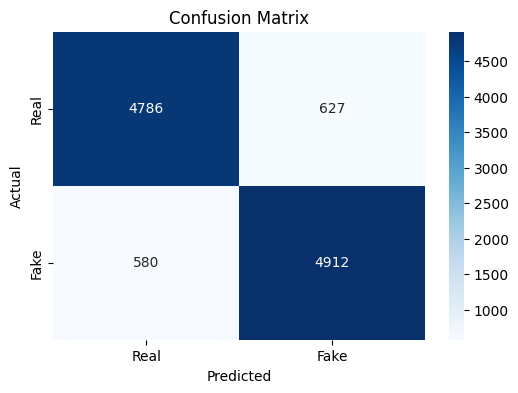

              precision    recall  f1-score   support

        Real       0.89      0.88      0.89      5413
        Fake       0.89      0.89      0.89      5492

    accuracy                           0.89     10905
   macro avg       0.89      0.89      0.89     10905
weighted avg       0.89      0.89      0.89     10905



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    '/content/data/Test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=['Real', 'Fake'],
    shuffle=False
)


y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


print(classification_report(y_true, y_pred_classes, target_names=['Real', 'Fake']))